In [1]:
import numpy as np
import matplotlib.pyplot as plt

from QKDfunctions import *

from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister, BasicAer, Aer
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit.circuit import Parameter
from qiskit.extensions import IdGate
from qiskit.providers.aer.noise import NoiseModel, errors

from IPython.display import display, Math, Latex, clear_output

# BB84 protocol
## Table of Contents:
* [Introduction & Theory](#intro)
* [Plain protocol](#protocol)
* [Working protocol with Eavesdropper](#eve)
* [Protocol on NV with Noise](#noise)


## Introduction & Theory <a class="anchor" id="intro"></a>

In the MDI protocol Alice prepares a random state $\mid+\rangle,\mid-\rangle,\mid0\rangle,\mid1\rangle$. She then sends this to Bob who chooses a random basis +/- or 0/1 to measure in. Afterwards they compare bases, if they chose the same basis they will have the same bit.

## Plain protocol <a class="anchor" id="protocol"></a>

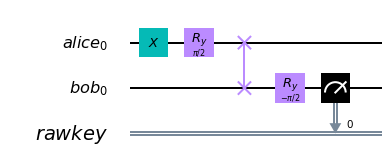

In [2]:
# Create the circuit
A = QuantumRegister(1, 'alice')
B = QuantumRegister(1, 'bob')
rawkey = ClassicalRegister(1, 'raw key')

qc = QuantumCircuit(A, B, rawkey)

# Add the gates
qc.x(A[0])
qc.ry(np.pi/2, A[0])
qc.swap(A[0], B[0])
qc.ry(-np.pi/2, B[0])
qc.measure(B[0], rawkey[0])

cplot=qc.draw(output='mpl')
display(cplot)

## Working protocol with Eavesdropper <a class="anchor" id="eve"></a>

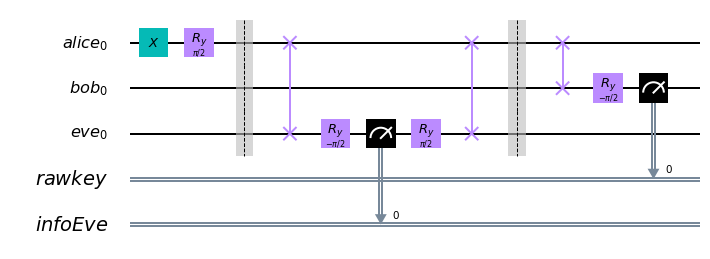

In [3]:
A = QuantumRegister(1, name = 'alice')
B = QuantumRegister(1, name = 'bob')
E = QuantumRegister(1, 'eve')
rawkey = ClassicalRegister(1, name = 'rawkey')
infoE = ClassicalRegister(1, "infoEve")

# Alice sends bit
circuit = QuantumCircuit(A, B, E, rawkey, infoE)    
circuit.x(A)       
circuit.ry(np.pi/2,A)

# Eve drops
circuit.barrier(A,B,E)
circuit.swap(A[0], E[0])
circuit.ry(-np.pi/2, E[0])
circuit.measure(E[0], infoE[0])
circuit.ry(np.pi/2, E[0])
circuit.swap(A[0], E[0])
circuit.barrier(A,B,E)

circuit.swap(A,B)

# Bob measures
circuit.ry(-np.pi/2, B)
circuit.measure(B,rawkey[0])

cplot=circuit.draw(output='mpl')
display(cplot)

In [4]:
#Code with Eve
N = 1000
chanceE = 1   # Chance Eve drops (1 = 100%)
print_table = False

# Setup
basisA = np.random.randint(2, size=N)   # 0 means 0/1 basis, 1 means +/-
basisB = np.random.randint(2, size=N)
basisE = np.random.choice([0,1,2], p=[0.5*chanceE, 0.5*chanceE, 1-chanceE], size=N)

dataA = np.random.randint(2, size=N)
dataB = np.zeros(N, dtype=int)
dataE = np.zeros(N, dtype=int)

A = QuantumRegister(1, name = 'alice')
B = QuantumRegister(1, name = 'bob')
E = QuantumRegister(1, 'eve')
rawkey = ClassicalRegister(1, name = 'rawkey')
infoE = ClassicalRegister(1, "infoEve")

if print_table:
    print('bit A | result E | result B ')
    print('----------------------------------')

keyA = np.zeros(N, dtype=int)
keyB = np.zeros(N, dtype=int)
M = 0  # counter for key

# Build and run the circuits
for i in range(N):
    circuit = QuantumCircuit(A, B, E, rawkey, infoE)
    # Alice sends bit
    if(dataA[i] == 1):    
        circuit.x(A)
    if(basisA[i] == 1):    
        circuit.ry(np.pi/2,0)
    
    # Eve drops (or doesnt)
    circuit.barrier(A,B,E)
    if basisE[i] == 0:
        circuit.swap(A[0], E[0])
        circuit.measure(E[0], infoE[0])
        circuit.swap(A[0], E[0])
    elif basisE[i] == 1:
        circuit.swap(A[0], E[0])
        circuit.ry(-np.pi/2, E[0])
        circuit.measure(E[0], infoE[0])
        circuit.ry(np.pi/2, E[0])
        circuit.swap(A[0], E[0])
    circuit.barrier(A,B,E)
    
    circuit.swap(A,B)
    
    # Bob measures
    if basisB[i] == 1:
        circuit.ry(-np.pi/2, B)
    circuit.measure(B, rawkey[0])
    
    # Run circuit
    backend = BasicAer.get_backend('qasm_simulator')
    shots = 1
    results = execute(circuit, backend=backend, shots=shots).result()
    counts = results.get_counts()
    k = list(counts.keys())[0]
    k = ' '.join(k)
    data = np.fromstring(k,sep=' ', dtype=int)
    dataE[i] = data[0]
    dataB[i] = data[1]
            
    bitA = give_bit(basisA[i], dataA[i])
    bitB = give_bit(basisB[i], dataB[i])
    bitE = give_bit(basisE[i], dataE[i])
    
    if basisA[i] == basisB[i]:
        keyA[M] = dataA[i]
        keyB[M] = dataB[i]
        M += 1

    if print_table: 
        print('   {0}  |     {1}    |   {2}'.format(bitA, bitE, bitB))
    else:
        # Show progress 
        print('Currently at: {0}/{1}  :  {2}%'.format(i+1, N, int(float((i+1))*100/N)))
        clear_output(wait=True)

keyA = keyA[0:M]
keyB = keyB[0:M]
QBER = np.sum(keyA != keyB)
print('QBER: {0}%'.format(int(QBER/M*100)))


QBER: 26%


## Protocol on NV with Noise <a class="anchor" id="noise"></a>

QBER: 0.10124999999999999 +/- 0.007189401922274202


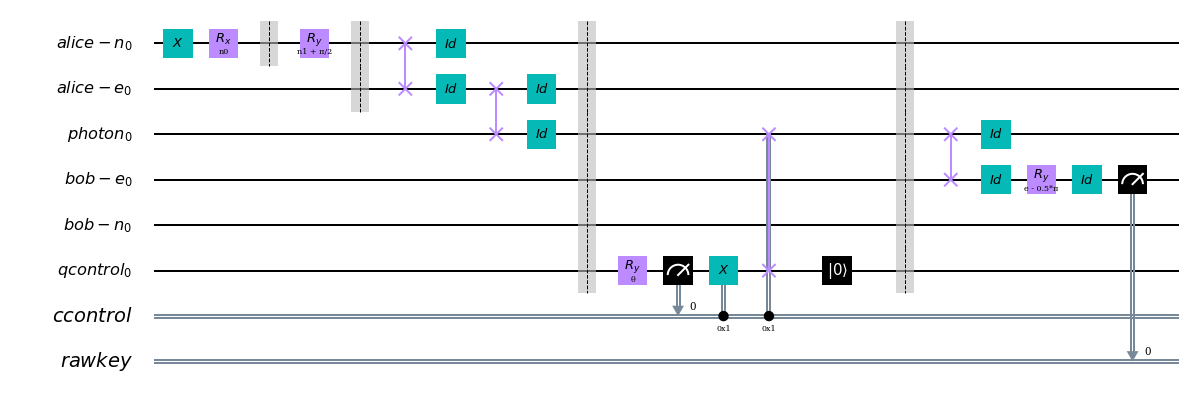

In [50]:
# Initialize variables 
N = 1000             # number of shots per pick
number_picks = 20    # Number of picks per set of sigmas
length = 0.05        # Length of photon fiber
att_length = 0.542   # in km
Fg = 1-0.98          # Depolarizing parameter for two qubit gates in quantum memories
Fprep = 1-0.99       # Dephasing parameter for the memory-photon state preparation
Fm = 1-0.95          # Depolarizing parameter for the measurement of the electron spin
noise_n = 0.142      # The 1-sigmas that will be used on carbon gates
noise_e = 0.142      # The 1-sigmas that will be used on electron gates

# Create the circuit
An = QuantumRegister(1, 'alice-n')
Ae = QuantumRegister(1, 'alice-e')
Bn = QuantumRegister(1, 'bob-n')
Be = QuantumRegister(1, 'bob-e')
p = QuantumRegister(1, 'photon')
control = QuantumRegister(1,'qcontrol')
init = ClassicalRegister(1,'ccontrol')
rawkey = ClassicalRegister(1, 'raw key')

qc = QuantumCircuit(An, Ae, p, Be, Bn, control, init, rawkey)

# Define parameters    !you need one for EACH gate!
pi_par = Parameter('π')     # Parameter to show pi nicely
noise_n0 = Parameter('n0')  # Parameter to control noise on carbon gates
noise_n1 = Parameter('n1')  # 
noise_e0 = Parameter('e')    # Parameter to control noise on electron gates
theta_par = Parameter('θ')  # Parameter to control relaxation noise of photon

# Alice chooses the bit and basis    (CHOOSE |->)
noisy_x(qc, An[0], noise=noise_n0)
qc.barrier(An)
noisy_ry(pi_par/2, qc, An[0], noise=noise_n1)
qc.barrier(An,Ae)
# Send and receive the photon
send_photon_swap(qc, An[0], Ae, Bn[0], Be, p, control, init, theta_par)
# Bob measures in the same basis
noisy_ry(-pi_par/2, qc, Be, noise=noise_e0)
noisy_measure(qc, Be, rawkey)

# DONT Loop through the parameters (YET)
theta_val = 2*np.arccos(np.exp(-length/(2*att_length)))
noise_depo = Fg
noise_deph = Fprep
noise_meas = Fm

backend = Aer.get_backend('qasm_simulator')

qber_pick = np.zeros(number_picks)

for randpick in range(number_picks):
    # Choose a random noise for the carbon and electron gates
    n0 = np.random.normal(scale=noise_n)
    n1 = np.random.normal(scale=noise_n)
    e0 = np.random.normal(scale=noise_e)

    noisemodel = NoiseModel()
    depo = errors.depolarizing_error(noise_depo, 1)
    deph = errors.phase_damping_error(noise_deph, 1)
    depo_meas = errors.depolarizing_error(noise_meas, 1)
    noisemodel.add_all_qubit_quantum_error(depo,'Cswap')
    noisemodel.add_all_qubit_quantum_error(deph,'eswap')
    noisemodel.add_all_qubit_quantum_error(depo_meas,'meas')

    circuit = qc.bind_parameters({pi_par: np.pi, noise_n0: n0, noise_n1: n1, noise_e0: e0, theta_par: theta_val})

    # Execute the circuit and save the qber
    job = execute(circuit, backend=backend, shots=N, noise_model=noisemodel, basis_gates=noisemodel.basis_gates)
    result = job.result()
    counts = result.get_counts()
    
    try:
        qber_pick[randpick] += counts['0 0']/N
    except:
        pass
    try:
        qber_pick[randpick] += counts['0 1']/N
    except:
        pass

    # Show progress 
    print('Currently at: {0}/{1}'.format(randpick, number_picks))
    clear_output(wait=True)

qber = np.mean(qber_pick)
qber_std = np.std(qber_pick)
print('QBER:', qber, '+/-', qber_std)
        
# Draw the circuit
display(qc.draw(output='mpl'))

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


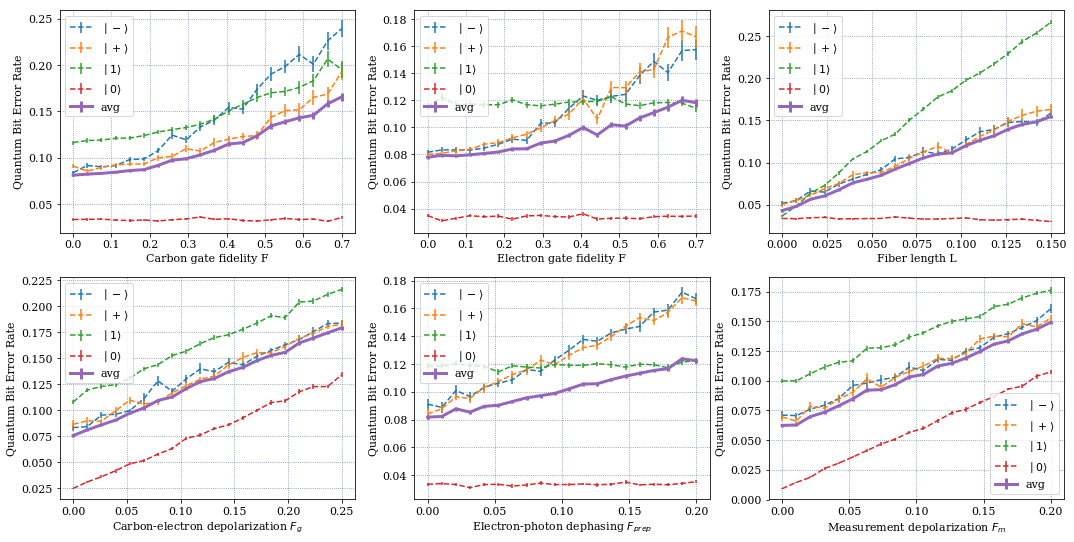

In [34]:
# Set the font
font = {'family' : 'serif', 'size' : 11}
plt.rc('font', **font)

titles = ['Carbon gate fidelity F', 'Electron gate fidelity F', 'Fiber length L', 'Carbon-electron depolarization $F_g$', 'Electron-photon dephasing $F_{prep}$', 'Measurement depolarization $F_m$']
noises = ['carbon', 'electron', 'length', 'depo', 'deph', 'meas']
states = ['-', '+', '1', '0']
labels = [r'$\mid- \rangle$', r'$\mid+ \rangle$', r'$\mid1 \rangle$', r'$\mid0 \rangle$']
noiselist = [0]*6
noiselist_std = [0]*6

for i, noise in enumerate(noises):
    noiselist[i] = np.loadtxt('data/bb84_'+noise)
    noiselist_std[i] = np.loadtxt('data/bb84_'+noise+'_std')

plot_noises(noiselist, noiselist_std, labels, titles)

In [35]:
noiselist[0][0,:] = 0.5*(np.exp(-0.5*(noiselist[0][0,:]**2))+1)
noiselist[1][0,:] = 0.5*(np.exp(-0.5*(noiselist[1][0,:]**2))+1)

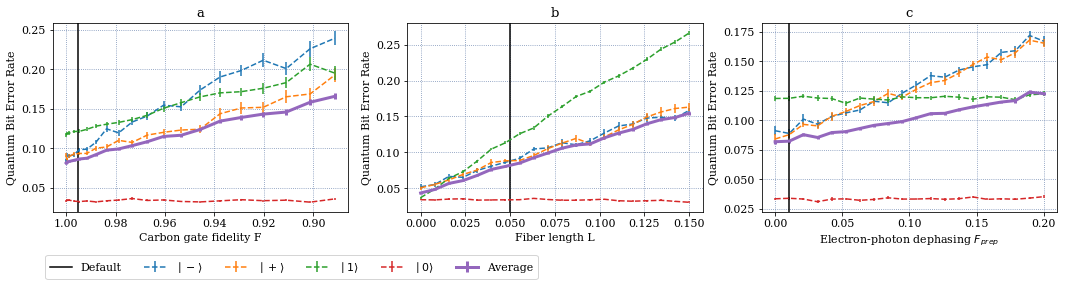

In [44]:
(noises, noises_std, labels, titles) = (noiselist, noiselist_std, labels, titles)
vlines = [0.995, 0.995, 0.05, 0.02, 0.01, 0.05]
numering = ['a', 'b', 'b', 'd', 'c', 'f']

fign = plt.figure(figsize=(18,8))
for k in range(2):
    for j in range(3):
        index = 3*k+j
        if index == 0: ax = fign.add_subplot(2,3,index+1)
        if index == 2: ax = fign.add_subplot(2,3,2)
        if index == 4: ax = fign.add_subplot(2,3,3)
        if index == 1 or index == 3 or index == 5:
            continue
        if index == 0 or index == 1:
            ax.invert_xaxis()
        avg_std = np.zeros(20)
        for i, l in enumerate(labels):
            ax.errorbar(noises[index][0,:],noises[index][i+1,:],yerr=noises_std[index][i,:], ls='--',label=l)
            avg_std += (noises_std[index][i,:]/(len(labels)))**2

        avg_std = np.sqrt(avg_std)

        ax.axvline(vlines[index], color='black', label='Default')
        ax.errorbar(noises[index][0,:],np.mean(noises[index][1:,:], axis=0), yerr=avg_std, linewidth=3.0,label='Average')
        ax.set_axisbelow(True)
        ax.grid(color='#6b84af', linestyle='dotted')
        plt.title(numering[index])
        plt.ylabel('Quantum Bit Error Rate')
        plt.xlabel(titles[index])
        if index == 0: plt.legend(ncol=6, bbox_to_anchor=(1.66, -0.2))
plt.subplots_adjust(hspace=0.3)
plt.savefig('bb84_plots.pdf')

OSError: [Errno 22] Invalid argument: 'allprotocols.pdf'

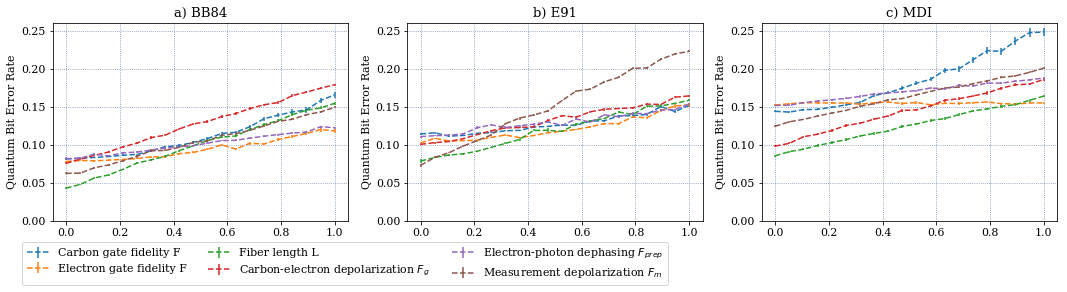

In [45]:
fign = plt.figure(figsize=(18,8))
titles = ['Carbon gate fidelity F', 'Electron gate fidelity F', 'Fiber length L', 'Carbon-electron depolarization $F_g$', 'Electron-photon dephasing $F_{prep}$', 'Measurement depolarization $F_m$']
noises = ['carbon', 'electron', 'length', 'depo', 'deph', 'meas']
plottitles = ['a) BB84', 'b) E91', 'c) MDI']
indexes = [4,2,6]

for nr, protocol in enumerate(['bb84', 'ek91', 'mdi']):
    for i, noise in enumerate(noises):
        noiselist[i] = np.loadtxt('data/'+protocol+'_'+noise)
        noiselist_std[i] = np.loadtxt('data/'+protocol+'_'+noise+'_std')
    
    ax = fign.add_subplot(2,3,1+nr)
    
    for index in range(6):
        avg_std = np.zeros(20)
        for i in range(indexes[nr]):
            avg_std += (noiselist_std[index][i,:]/(len(labels)))**2

        avg_std = np.sqrt(avg_std)
        
        ax.errorbar(np.linspace(0,1,20),np.mean(noiselist[index][1:,:], axis=0), yerr=avg_std, ls='--', linewidth=1.5,label=titles[index])
        ax.set_axisbelow(True)
        ax.grid(color='#6b84af', linestyle='dotted')
        plt.title(plottitles[nr])
        plt.ylabel('Quantum Bit Error Rate')
        plt.ylim(0,0.26)
        if nr == 0: plt.legend(ncol=3, bbox_to_anchor=(2.1, -0.08))
plt.savefig('allprotocols.pdf')

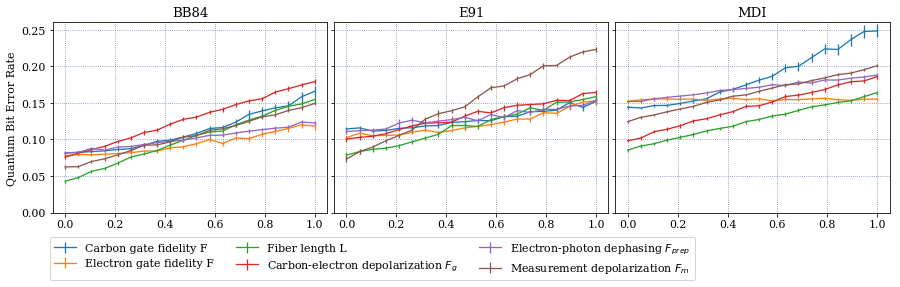

In [30]:
import matplotlib.gridspec as gridspec

fign = plt.figure(figsize=(15,3.5))
titles = ['Carbon gate fidelity F', 'Electron gate fidelity F', 'Fiber length L', 'Carbon-electron depolarization $F_g$', 'Electron-photon dephasing $F_{prep}$', 'Measurement depolarization $F_m$']
plottitles = ['BB84', 'E91', 'MDI']
noises = ['carbon', 'electron', 'length', 'depo', 'deph', 'meas']

gs1 = gridspec.GridSpec(1, 3)
gs1.update(wspace=0.025, hspace=0.05)

for nr, protocol in enumerate(['bb84', 'ek91', 'mdi']):
    for i, noise in enumerate(noises):
        noiselist[i] = np.loadtxt('data/'+protocol+'_'+noise)
        noiselist_std[i] = np.loadtxt('data/'+protocol+'_'+noise+'_std')
    
    ax = fign.add_subplot(gs1[nr])#1,3,1+nr)
    for index in range(6):
        ax.errorbar(np.linspace(0,1,20),np.mean(noiselist[index][1:,:], axis=0), yerr=np.mean(noiselist_std[index][:,:], axis=0), ls='-', linewidth=1.3,label=titles[index])
        ax.set_axisbelow(True)
        ax.grid(color='#6b84af', linestyle='dotted')
        plt.title(plottitles[nr])
        plt.ylabel('Quantum Bit Error Rate')
        plt.ylim(0,0.26)
        if nr == 0: plt.legend(ncol=3, bbox_to_anchor=(2.36, -0.1))
for ax in fign.get_axes():
    ax.label_outer()

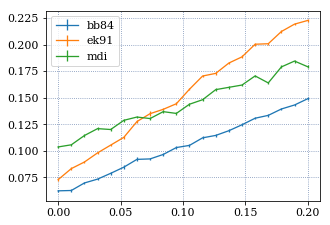

In [67]:
import matplotlib.gridspec as gridspec

fign = plt.figure(figsize=(15,3.5))
titles = ['Carbon gate fidelity F', 'Electron gate fidelity F', 'Fiber length L', 'Carbon-electron depolarization $F_g$', 'Electron-photon dephasing $F_{prep}$', 'Measurement depolarization $F_m$']
plottitles = ['BB84', 'E91', 'MDI']
noises = ['carbon', 'electron', 'length', 'depo', 'deph', 'meas']
indexes = [4,2,6]

noiselist = ['']*3
noiselist_std = ['']*3

ax = fign.add_subplot(gs1[nr])#1,3,1+nr)
ax.set_axisbelow(True)
ax.grid(color='#6b84af', linestyle='dotted')
for nr, protocol in enumerate(['bb84', 'ek91', 'mdi']):
    noiselist[nr] = np.loadtxt('data/'+protocol+'_'+'meas')
    noiselist_std[nr] = np.loadtxt('data/'+protocol+'_meas_std')
    
    avg_std = np.zeros(20)
    for i in range(indexes[nr]):
        avg_std += (noiselist_std[nr][i,:]/(len(labels)))**2
    avg_std = np.sqrt(avg_std)
    
    ax.errorbar(noiselist[nr][0,:],np.mean(noiselist[nr][1:,:], axis=0), yerr=avg_std, ls='-', linewidth=1.3,label=protocol)
plt.legend()

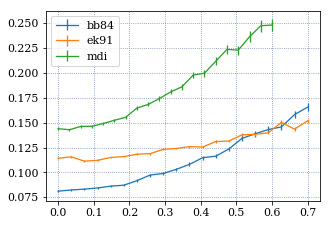

In [66]:
fign = plt.figure(figsize=(15,3.5))
titles = ['Carbon gate fidelity F', 'Electron gate fidelity F', 'Fiber length L', 'Carbon-electron depolarization $F_g$', 'Electron-photon dephasing $F_{prep}$', 'Measurement depolarization $F_m$']
plottitles = ['BB84', 'E91', 'MDI']
noises = ['carbon', 'electron', 'length', 'depo', 'deph', 'meas']
indexes = [4,2,6]

noiselist = ['']*3
noiselist_std = ['']*3

ax = fign.add_subplot(gs1[nr])#1,3,1+nr)
ax.set_axisbelow(True)
ax.grid(color='#6b84af', linestyle='dotted')
for nr, protocol in enumerate(['bb84', 'ek91', 'mdi']):
    noiselist[nr] = np.loadtxt('data/'+protocol+'_'+'carbon')
    noiselist_std[nr] = np.loadtxt('data/'+protocol+'_carbon_std')
    
    #if protocol == 'mdi': noiselist[nr][0,:] *= 2
    
    avg_std = np.zeros(20)
    for i in range(indexes[nr]):
        avg_std += (noiselist_std[nr][i,:]/(len(labels)))**2
    avg_std = np.sqrt(avg_std)
    
    ax.errorbar(noiselist[nr][0,:],np.mean(noiselist[nr][1:,:], axis=0), yerr=avg_std, ls='-', linewidth=1.3,label=protocol)
#plt.xlim(0,0.12)
plt.legend()